In [1]:
!pip install -q evaluate
!pip install transformers -q
!pip install datasets -q
!pip install sentence_transformers -q

In [2]:
import pandas as pd
import numpy as np
import copy
import json
import torch
import time
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoConfig, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import DataCollatorWithPadding, DefaultDataCollator
from torch.utils.data import DataLoader
from datasets import Dataset
from datasets import load_metric,load_dataset, Dataset, list_datasets
from transformers import AdamW
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from tqdm.notebook import tqdm
tqdm.pandas()
import torch.nn as nn
import torch.nn.functional as F
import gc
# from tqdm import tqdm
import os
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = "False"
from transformers import AutoModel, AutoConfig, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import DataCollatorWithPadding, DefaultDataCollator
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

In [3]:
class Config:
    max_length = 384
    doc_stride = 128
    train_batch_size = 12
    valid_batch_size = 2*train_batch_size
    n_accumulate = 1
    n_folds = 5
    num_epochs = 1
    collate_fn = DefaultDataCollator()
    lr = 5e-6
    min_lr = 1e-6
    seed = 42
    device = "cuda:0" if torch.cuda.is_available() else 'cpu'
    model_name = "deepset/deberta-v3-base-squad2"
    tokenizer = None
    
config = Config()
config.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

Downloading:   0%|          | 0.00/379 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [4]:
def seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed(config.seed)

In [5]:
squad_metric = load_metric("squad_v2")
squad_val = load_dataset('squad_v2', split = "validation")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


In [6]:
squad_val

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})

In [7]:
squad_val.set_format("pandas")
df_pandas = squad_val.to_pandas()

In [8]:
df_pandas

,id,title,context,question,answers
0,56ddde6b9a695914005b9628,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,"{'text': ['France', 'France', 'France', 'Franc..."
1,56ddde6b9a695914005b9629,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,"{'text': ['10th and 11th centuries', 'in the 1..."
2,56ddde6b9a695914005b962a,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"{'text': ['Denmark, Iceland and Norway', 'Denm..."
3,56ddde6b9a695914005b962b,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,"{'text': ['Rollo', 'Rollo', 'Rollo', 'Rollo'],..."
4,56ddde6b9a695914005b962c,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,"{'text': ['10th century', 'the first half of t..."
...,...,...,...,...,...
11868,5737aafd1c456719005744ff,Force,"The pound-force has a metric counterpart, less...",What is the seldom used force unit equal to on...,"{'text': ['sthène', 'sthène', 'sthène', 'sthèn..."
11869,5ad28ad0d7d075001a4299cc,Force,"The pound-force has a metric counterpart, less...",What does not have a metric counterpart?,"{'text': [], 'answer_start': []}"
11870,5ad28ad0d7d075001a4299cd,Force,"The pound-force has a metric counterpart, less...",What is the force exerted by standard gravity ...,"{'text': [], 'answer_start': []}"
11871,5ad28ad0d7d075001a4299ce,Force,"The pound-force has a metric counterpart, less...",What force leads to a commonly used unit of mass?,"{'text': [], 'answer_start': []}"


In [9]:
df_gen = pd.read_csv('/kaggle/input/new-qa-with-idx-squad-validation/new_qa_with_idx_squad_validation.csv')

In [10]:
for i in range(len(df_gen)):
        if (len(df_gen['Answer_text'][i]) == 0):
            df_gen['Answer_possible'].iloc[i] = 0
        else:
            df_gen['Answer_possible'].iloc[i] = 1

In [11]:
df_gen.insert(0, 'id', df_gen.index)

In [12]:
df_gen.rename(columns={df_gen.columns[0]:'id', 'Paragraph':'context',
                       'Question':'question',
                       'Answer_start':'answer_start',
                       'Answer_possible':'answer_possible'}, inplace=True)

In [13]:
new = []
for x in df_gen['Answer_text']:
        if x != '[]':
            new.append('['+x+']')
        else:
            new.append(x)
df_gen['answer'] = new

In [14]:
df_gen['answer_start'] = df_gen['answer_start'].apply(lambda x: [x])
df_gen['answer_end'] = (df_gen['answer_start'].apply(lambda x:x[0]) + df_gen['Answer_text'].apply(lambda x:len(x[0]) if len(x)>0 else 0)).apply(lambda x:[x])

In [15]:
def prepare_answer(row):
    if len(row['Answer_text']) == 0:
        out = {'text': '' , 'answer_start': row['answer_start'][0]}
    else:
        out = {'text': row['Answer_text'] , 'answer_start': row['answer_start'][0]}

    return out

df_gen = df_gen.assign(answers=df_gen.apply(prepare_answer , axis=1))

In [16]:
df_gen.head()

,id,Answer_text,question,context,answer_start,Theme,answer_possible,answer,answer_end,answers
0,0,Normandy,What did the Normans give their name to in the...,The Normans (Norman: Nourmands; French: Norman...,[137],Normans,1,[Normandy],[138],"{'text': 'Normandy', 'answer_start': 137}"
1,1,Norse,What language were the Normans descended from?,The Normans (Norman: Nourmands; French: Norman...,[192],Normans,1,[Norse],[193],"{'text': 'Norse', 'answer_start': 192}"
2,2,Carolingian,Along with the Frankish and Roman-Gaulish popu...,The Normans (Norman: Nourmands; French: Norman...,[527],Normans,1,[Carolingian],[528],"{'text': 'Carolingian', 'answer_start': 527}"
3,3,the first half of the 10th century,When did the distinct cultural and ethnic iden...,The Normans (Norman: Nourmands; French: Norman...,[649],Normans,1,[the first half of the 10th century],[650],"{'text': 'the first half of the 10th century',..."
4,4,The Norman dynasty,"Which dynasty had a major political, cultural ...","The Norman dynasty had a major political, cult...",[0],Normans,1,[The Norman dynasty],[1],"{'text': 'The Norman dynasty', 'answer_start': 0}"


In [17]:
df_gen['Theme'].value_counts()

Yuan_dynasty                                 270
Immune_system                                267
French_and_Indian_War                        249
European_Union_law                           218
Warsaw                                       211
Imperialism                                  208
Force                                        202
Steam_engine                                 189
Rhine                                        182
Huguenot                                     177
Scottish_Parliament                          174
Economic_inequality                          170
Normans                                      170
Computational_complexity_theory              159
Oxygen                                       159
Ctenophora                                   158
University_of_Chicago                        152
Fresno,_California                           147
Islamism                                     145
Harvard_University                           139
Jacksonville,_Florid

In [18]:
df_pandas['title'].value_counts()

Economic_inequality                          515
Rhine                                        498
Warsaw                                       486
Immune_system                                458
Yuan_dynasty                                 445
Steam_engine                                 444
Huguenot                                     424
European_Union_law                           421
Computational_complexity_theory              418
Oxygen                                       415
French_and_Indian_War                        402
Islamism                                     384
Force                                        377
Packet_switching                             373
Imperialism                                  364
Geology                                      362
Scottish_Parliament                          357
University_of_Chicago                        356
Civil_disobedience                           327
Ctenophora                                   325
Southern_California 

In [19]:
df_pandas['title'].unique()

array(['Normans', 'Computational_complexity_theory',
       'Southern_California', 'Sky_(United_Kingdom)',
       'Victoria_(Australia)', 'Huguenot', 'Steam_engine', 'Oxygen',
       '1973_oil_crisis', 'European_Union_law', 'Amazon_rainforest',
       'Ctenophora', 'Fresno,_California', 'Packet_switching',
       'Black_Death', 'Geology', 'Pharmacy', 'Civil_disobedience',
       'Construction', 'Private_school', 'Harvard_University',
       'Jacksonville,_Florida', 'Economic_inequality',
       'University_of_Chicago', 'Yuan_dynasty', 'Immune_system',
       'Intergovernmental_Panel_on_Climate_Change', 'Prime_number',
       'Rhine', 'Scottish_Parliament', 'Islamism', 'Imperialism',
       'Warsaw', 'French_and_Indian_War', 'Force'], dtype=object)

## To create new clusters

In [12]:
# from sentence_transformers import SentenceTransformer

In [13]:
# phrase_bert = SentenceTransformer('whaleloops/phrase-bert')

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/670 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [20]:
# val_ls = list(np.unique(df_pandas['title']))

In [15]:
# theme_emb = phrase_bert.encode(val_ls)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# kmeans = KMeans(n_clusters=10, init='k-means++',max_iter=300)
# clustering = kmeans.fit(theme_emb)

In [16]:
# clustering.labels_

array([8, 5, 0, 0, 1, 1, 6, 1, 4, 0, 0, 3, 1, 2, 5, 6, 7, 8, 7, 3, 5, 9,
       9, 6, 1, 2, 5, 4, 4, 3, 9, 2, 4, 5, 5], dtype=int32)

In [17]:
# clusters = {}

In [18]:
# for i in range(0,9):
#     clusters[i] = list(val_ls[clustering.labels_ == i])

In [ ]:
# clusters

In [29]:
# squad_metric = load_metric("squad_v2")
# squad_val = load_dataset('squad_v2', split = "validation")
# squad_train = load_dataset('squad_v2', split = "train")

In [30]:
# squad_train = squad_train.to_pandas()
# squad_val = squad_val.to_pandas()
# train_ls = list(np.unique(squad_train['title']))
# val_ls = list(np.unique(squad_val['title']))
# # train_ls.extend(val_ls)
# total_ls = np.unique(val_ls)
# train_ls = list(np.unique(squad_train['title']))

In [31]:
# theme_emb = phrase_bert.encode(total_ls)
# kmeans = KMeans(n_clusters=10, init='k-means++',max_iter=300)
# clustering = kmeans.fit(theme_emb)
# clusters = {}
# for i in range(0,9):
#     clusters[i] = list(total_ls[clustering.labels_==i])

In [32]:
# theme_emb = phrase_bert.encode(total_ls)
# clustering = AffinityPropagation(random_state= 0, verbose=True).fit(theme_emb)
# clusters = {}
# for i in range(0, 6):
#     clusters[i] = list(total_ls[clustering.labels_==i])

NameError: name 'phrase_bert' is not defined

In [29]:
# clusters

{0: ['1973_oil_crisis',
  'Black_Death',
  'Civil_disobedience',
  'Construction',
  'Economic_inequality',
  'Force',
  'French_and_Indian_War',
  'Imperialism',
  'Islamism'],
 1: ['European_Union_law', 'Scottish_Parliament', 'Sky_(United_Kingdom)'],
 2: ['Harvard_University', 'Private_school', 'University_of_Chicago'],
 3: ['Computational_complexity_theory',
  'Ctenophora',
  'Geology',
  'Immune_system',
  'Intergovernmental_Panel_on_Climate_Change',
  'Oxygen',
  'Packet_switching',
  'Pharmacy',
  'Prime_number',
  'Steam_engine'],
 4: ['Amazon_rainforest',
  'Huguenot',
  'Normans',
  'Rhine',
  'Warsaw',
  'Yuan_dynasty'],
 5: ['Fresno,_California',
  'Jacksonville,_Florida',
  'Southern_California',
  'Victoria_(Australia)']}

In [30]:
# file = open("clusters-val_ap.json","w")
# file.write(json.dumps(clusters))
# file.close()

## Import clusters from file

In [21]:
import json
f = open('/kaggle/input/prevkmeanscluster/clusters.json')
clusters = json.load(f)
f.close()

In [22]:
clusters['0']

['ASCII',
 'Alexander_Graham_Bell',
 'Alfred_North_Whitehead',
 'Annelid',
 'Apollo',
 'Arnold_Schwarzenegger',
 'Athanasius_of_Alexandria',
 'Avicenna',
 'Baptists',
 'Bern',
 'Beyoncé',
 'Bras%C3%ADlia',
 'Buckingham_Palace',
 'Cardinal_(Catholicism)',
 'Christian',
 'Crucifixion_of_Jesus',
 'Dell',
 'Dominican_Order',
 'Dwight_D._Eisenhower',
 'Edmund_Burke',
 'Elizabeth_II',
 'Everton_F.C.',
 'Friedrich_Hayek',
 'Frédéric_Chopin',
 'George_VI',
 'God',
 'Hanover',
 'Huguenot',
 'Immaculate_Conception',
 'Jehovah%27s_Witnesses',
 'John,_King_of_England',
 'John_Kerry',
 'John_von_Neumann',
 'Josip_Broz_Tito',
 'Karl_Popper',
 'Macintosh',
 'Madonna_(entertainer)',
 'Mary_(mother_of_Jesus)',
 'Napoleon',
 'Neptune',
 'Palermo',
 'Pope_John_XXIII',
 'Pope_Paul_VI',
 'Queen_(band)',
 'Queen_Victoria',
 'Richard_Feynman',
 'Royal_Dutch_Shell',
 'Saint_Barth%C3%A9lemy',
 'Saint_Helena',
 'Somerset',
 'Steven_Spielberg',
 'The_Legend_of_Zelda:_Twilight_Princess',
 'Tristan_da_Cunha',
 'Va

In [23]:
themes = df_pandas['title'].unique()

In [24]:
score_df = pd.DataFrame(themes)

In [25]:
score_df_van = pd.DataFrame(themes)

In [26]:
score_df.insert(1, 'F1', 0)
score_df.insert(2, 'EM', 0)

In [27]:
score_df_van.insert(1, 'F1', 0)
score_df_van.insert(2, 'EM', 0)

In [28]:
def process_text(inp, tokenizer=config.tokenizer, config=config):
    tokenized_inp = tokenizer(inp['question'],
                             inp['context'],
                              add_special_tokens=True,
                             truncation='only_second',
                             max_length=config.max_length,
                             stride=config.doc_stride,
                             return_offsets_mapping=True,
                             return_overflowing_tokens=True,
                             padding='max_length',
                             return_token_type_ids=True)
    sample_mapping = tokenized_inp.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_inp.pop("offset_mapping")
    start_positions = []
    end_positions = []
    
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_inp["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_inp.sequence_ids(i)
        sample_index = sample_mapping[i]
        if inp['answer_possible'][sample_index] == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = inp["answer_start"][sample_index][0]
            end_char = inp['answer_end'][sample_index][0]
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)
    tokenized_inp["start_positions"] = start_positions
    tokenized_inp["end_positions"] = end_positions
    return tokenized_inp

In [29]:
class QA(nn.Module):
    def __init__(self):
        super(QA, self).__init__()
        self.model = AutoModelForQuestionAnswering.from_pretrained(config.model_name)

    def forward(self, ids, mask, token_type_ids):
        if config.model_name.split('-')[0]=='distilbert':
            out = self.model(ids, attention_mask=mask)
        else:
            out = self.model(ids, attention_mask=mask, token_type_ids=token_type_ids)
        return out.start_logits, out.end_logits

In [30]:
def criterion(out1, out2, inp1, inp2):
    l1 = nn.CrossEntropyLoss()(out1, inp1)
    l2 = nn.CrossEntropyLoss()(out2, inp2)
    return l1+l2

In [31]:
def train_epoch(model, data_loader, optimizer, scheduler, epoch, device):
    model.train()   
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, data in bar:
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device) 
        inp1 = data['start_positions'].to(device)
        inp2 = data['end_positions'].to(device) 
        batch_size = ids.size(0)
        out1, out2 = model(ids, mask=mask, token_type_ids=token_type_ids)
        loss = criterion(out1, out2, inp1, inp2)
        loss = loss / config.n_accumulate
        loss.backward()       
        del inp1,inp2,out1,out2         
        if (step + 1) % config.n_accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()           
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size      
        epoch_loss = running_loss / dataset_size  
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    return epoch_loss

In [32]:
def train(model, optimizer, scheduler, num_epochs, train_loader, fold, device):
    best_epoch_loss = np.inf
    best_model_wts = {}   
    history = {'Train_loss':[], "Valid_loss":[]}
    for epoch in range(1, num_epochs+1): 
        train_epoch_loss = train_epoch(model, train_loader, optimizer, scheduler, epoch, device)
        history['Train_loss'].append(train_epoch_loss)
        best_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"Loss-Fold-{fold}.bin"
        torch.save(model.state_dict(), PATH)
        print(f"Model Saved")
    model.state_dict(best_model_wts)
    return model, history

In [33]:
def optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    return optimizer_parameters

In [34]:
def evaluate(example):
    default = distil_model(question=example['question'], context=example['context'])
    return {
        'reference': {'id': example['id'], 'answers': example['answers']},
        'default': {'id': example['id'],'prediction_text': default['answer'], 'no_answer_probability': 0.}
      }

## Trained on Themes

In [35]:
def preprocess_sq2(df, df_gen):
    df.insert(3,'answer_possible', 0)
    df.insert(4, 'Answer_text', 0)
    df.insert(5, 'Answer_start', 0)

    for i in range(len(df)):
        if (len(df['answers'].iloc[i]['answer_start']) == 0):
            continue
        else:
            df['answer_possible'].iloc[i] = 1

    for i in (range(len(df))):
        if (len(df['answers'].iloc[i]['answer_start']) == 0):
            df['Answer_text'].iloc[i] = '[]'
            df['Answer_start'].iloc[i] = 0
            continue
        else:
            df['Answer_text'].iloc[i] = df['answers'].iloc[i]['text'][0]
            df['Answer_start'].iloc[i] = df['answers'].iloc[i]['answer_start'][0]
    new = []
    for x in df['Answer_text']:
        if x != '[]':
            new.append('['+x+']')
        else:
            new.append(x)
    df['answer'] = new
    df['Answer_start'] = df['Answer_start'].apply(lambda x: [x])
    df['answer_end'] = (df['Answer_start'].apply(lambda x:x[0]) + df['Answer_text'].apply(lambda x:len(x[0]) if len(x)>0 else 0)).apply(lambda x:[x])
    df.rename(columns={df.columns[0]:'id', 'context':'context',
                       'question':'question',
                       'Answer_start':'answer_start',
                       'Answer_possible':'answer_possible'}, inplace=True)
    df['context'] = df['context'].apply(lambda t : t.strip())
    df = df.drop(['Answer_text'], axis=1)
    df = df.drop(['id'], axis = 1)
    df['id'] = df.index
    df.rename(columns={ 'title':'Theme'}, inplace=True)
    
    df['fold'] = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    for i, (train_index, val_index) in enumerate(kf.split(df)):
        df.iloc[val_index]["fold"] = i

    train_df, val_df = train_test_split(df, test_size=0.7, stratify=df['fold'])
    train_df.append(df_gen, ignore_index = True)
    return train_df, val_df,df

In [36]:
def train_sq2(model, dataset, df):
    for fold in range(config.n_folds):
        dataset = dataset.reset_index(drop=True)
        train_dataset = Dataset.from_pandas(dataset).map(process_text, batched=True, remove_columns=list(df.columns))
        train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, collate_fn=config.collate_fn, 
                                      num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
        num_train_steps = int(len(train_dataset) / config.train_batch_size * config.num_epochs)
        model = model
        model.to(config.device)
        optimizer = AdamW(optimizer_params(model), lr=config.lr)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= (0.1 * num_train_steps), num_training_steps=num_train_steps)    
        model, history = train(model, 
                                   optimizer, 
                                   scheduler, 
                                   config.num_epochs, 
                                   train_loader, 
                                   fold, 
                                   device=config.device)
        torch.save(model.state_dict(), 'deberta_v3_new.pt')
        del history, train_loader 
        _ = gc.collect()
        print()
        break
    return model

In [37]:
def evaluate_sq2(model,dataset):
    results = dataset.progress_apply(evaluate, axis =1)

    predictions = []
    for i in range(len(results)):
        pred = results.iloc[i]['default']
        predictions.append(pred)
    references = []
    for i in (range(len(results))):
        ref = results.iloc[i]['reference']
        references.append(ref)
    default = squad_metric.compute(predictions=predictions, references=references)
    return default

In [38]:
def evaluate_van(model, dataset):
    results = dataset.progress_apply(evaluate, axis =1)

    predictions = []
    for i in range(len(results)):
        pred = results.iloc[i]['default']
        predictions.append(pred)
    references = []
    for i in (range(len(results))):
        ref = results.iloc[i]['reference']
        references.append(ref)
    default = squad_metric.compute(predictions=predictions, references=references)
    return default

In [39]:
df = pd.DataFrame(columns = df_pandas.columns)
for theme in clusters['0']:
        if theme in val_ls:
            df = pd.concat([df,df_pandas[df_pandas['title']==theme]], axis=0)

In [40]:
# train_df[:2]

In [ ]:
for j in tqdm(clusters.keys()):
    print("Cluster ",j)
    df = pd.DataFrame(columns = df_pandas.columns)
    df_gen1 = pd.DataFrame(columns = df_gen.columns)
    for theme in clusters[j]:
        if theme in val_ls:
            df = pd.concat([df,df_pandas[df_pandas['title']==theme]], axis=0)
            df_gen1 = pd.concat([df_gen1,df_gen1[df_gen1['Theme']==theme]], axis=0)
    train_df, val_df, df_pre = preprocess_sq2(df, df_gen1)
    pad_on_right = config.tokenizer.padding_side == "right"
    model = QA()
    model = train_sq2(model, train_df, df_pre)
    if not os.path.exists("deberta_v3_new"):
        os.mkdir("deberta_v3_new")
    torch.save(model.state_dict(), f'deberta_v3_new/deberta_v3_new.pt')
    
    model = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-base-squad2")
    tokenizer = AutoTokenizer.from_pretrained("deepset/deberta-v3-base-squad2")
    state_dict = torch.load(f'/kaggle/working/deberta_v3_new/deberta_v3_new.pt')
    new_state_dict = model.state_dict()
    for key in list(state_dict.keys()):
        new_key = key.replace("model.","")
        new_state_dict[new_key] = state_dict[key]
    model.load_state_dict(new_state_dict)
    distil_model = pipeline("question-answering",model=model,tokenizer = tokenizer, handle_impossible_answer=True, device=0)
    
    default = evaluate_sq2(model,val_df)
    score_df['F1'][int(j)] = default['f1']
    score_df['EM'][int(j)] = default['exact']
    del model
    _ = gc.collect()
    print(default)
    model2 = AutoModelForQuestionAnswering.from_pretrained("deepset/deberta-v3-base-squad2")
    tokenizer2 = AutoTokenizer.from_pretrained("deepset/deberta-v3-base-squad2")
    distil_model = pipeline("question-answering",model= model2,tokenizer = tokenizer2, handle_impossible_answer=True, device=0)
    default = evaluate_van(model= model2, dataset=val_df)
    score_df_van['F1'][int(j)] = default['f1']
    score_df_van['EM'][int(j)] = default['exact']
    _ = gc.collect()
    print(default)

  0%|          | 0/9 [00:00<?, ?it/s]

Cluster  0


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved



  0%|          | 0/297 [00:00<?, ?it/s]

{'exact': 82.82828282828282, 'f1': 86.10536582758803, 'total': 297, 'HasAns_exact': 80.41958041958041, 'HasAns_f1': 87.22582972582974, 'HasAns_total': 143, 'NoAns_exact': 85.06493506493507, 'NoAns_f1': 85.06493506493507, 'NoAns_total': 154, 'best_exact': 82.82828282828282, 'best_exact_thresh': 0.0, 'best_f1': 86.10536582758803, 'best_f1_thresh': 0.0}


  0%|          | 0/297 [00:00<?, ?it/s]

{'exact': 83.16498316498317, 'f1': 86.2175992731548, 'total': 297, 'HasAns_exact': 81.11888111888112, 'HasAns_f1': 87.45892995892997, 'HasAns_total': 143, 'NoAns_exact': 85.06493506493507, 'NoAns_f1': 85.06493506493507, 'NoAns_total': 154, 'best_exact': 83.16498316498317, 'best_exact_thresh': 0.0, 'best_f1': 86.2175992731548, 'best_f1_thresh': 0.0}
Cluster  1


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Model Saved



In [ ]:
score_df.to_csv('final_score_df.csv', index = False, encoding='utf-8')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
score_df_van.to_csv('final_score_van_df.csv', index = False, encoding='utf-8')

In [56]:
score_df_van.rename(columns={'F1': 'F1-van',
                   'EM': 'EM-van'},
          inplace=True, errors='raise')

In [57]:
score_df = score_df.join(score_df_van['F1-van'])

In [58]:
score_df = score_df.join(score_df_van['EM-van'])

In [63]:
score_df

,Clusters,F1,EM,F1-van,EM-van
0,1,90,87,89,85
1,2,86,81,88,83
2,3,83,80,81,78
3,4,88,82,88,84
4,5,84,79,86,82
5,6,87,84,84,80
6,7,87,84,87,85
7,8,91,88,91,89
8,9,89,84,88,84


In [62]:
score_df.drop([0], axis = 1, inplace = True) 

In [60]:
score_df = score_df[:9]

In [61]:
score_df.insert(0, 'Clusters', ['1','2','3', '4','5','6', '7', '8', '9'])

In [64]:
score_df.to_csv('score_cluster_gen_val_df.csv', index = False, encoding='utf-8')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, '9'),
  Text(0.0, 0, '1'),
  Text(1.0, 0, '2'),
  Text(2.0, 0, '3'),
  Text(3.0, 0, '4'),
  Text(4.0, 0, '5'),
  Text(5.0, 0, '6'),
  Text(6.0, 0, '7'),
  Text(7.0, 0, '8'),
  Text(8.0, 0, '9'),
  Text(9.0, 0, '')])

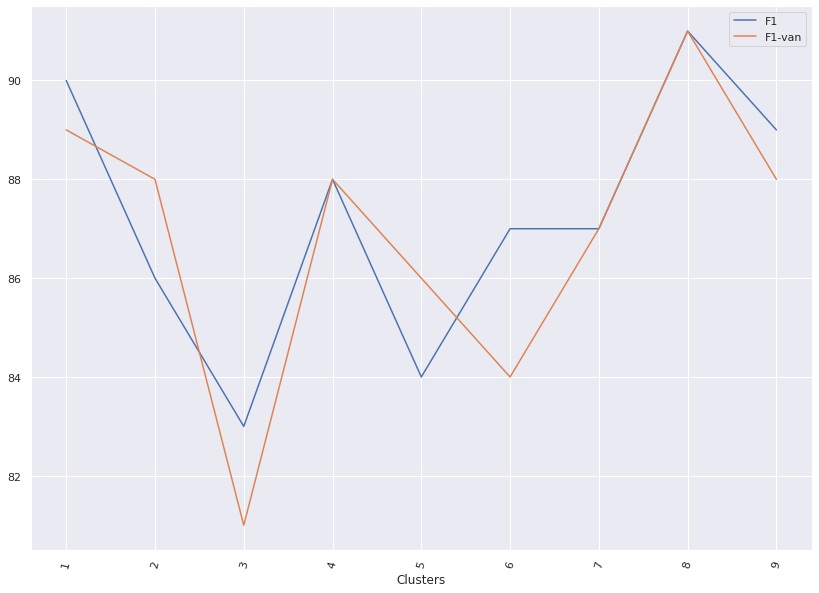

In [65]:
sns.set()
score_df.plot(x=0, y=["F1", "F1-van"], figsize=(14, 10))
plt.xticks(rotation=75)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, '9'),
  Text(0.0, 0, '1'),
  Text(1.0, 0, '2'),
  Text(2.0, 0, '3'),
  Text(3.0, 0, '4'),
  Text(4.0, 0, '5'),
  Text(5.0, 0, '6'),
  Text(6.0, 0, '7'),
  Text(7.0, 0, '8'),
  Text(8.0, 0, '9'),
  Text(9.0, 0, '')])

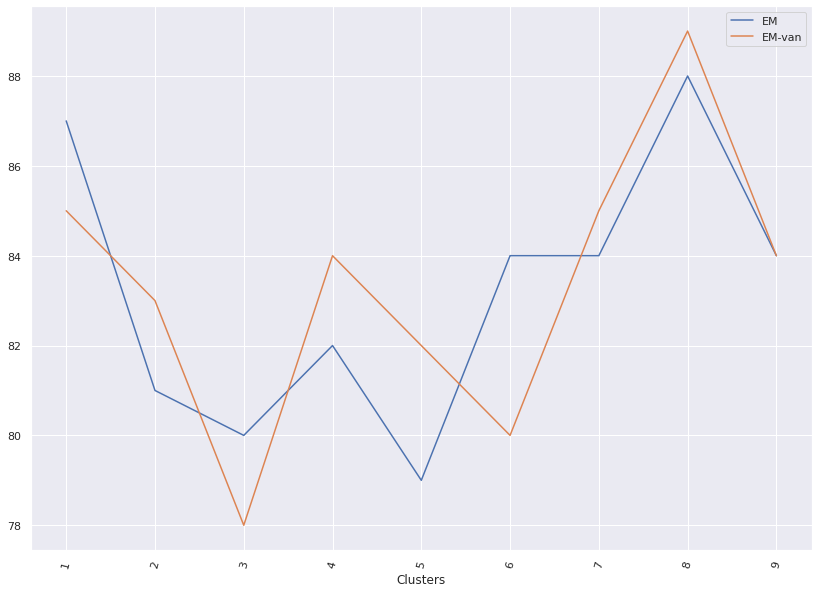

In [66]:
sns.set()
score_df.plot(x=0, y=["EM", "EM-van"], figsize=(14, 10))
plt.xticks(rotation=75)

In [67]:
score_df['F1'].mean()

87.22222222222223

In [68]:
score_df['F1-van'].mean()

86.88888888888889

In [69]:
score_df.mean()

Clusters    1.371742e+07
F1          8.722222e+01
EM          8.322222e+01
F1-van      8.688889e+01
EM-van      8.333333e+01
dtype: float64

In [70]:
score_df.var()

F1         6.944444
EM         9.194444
F1-van     8.611111
EM-van    10.000000
dtype: float64